The goal of this notebook is to find the "most important" OTUs in the population (i.e. in each original dataset).

We'll do this based on the signal to noise ratio, which will be defined as the delta divided by the variance. We might need to do some checks though and make sure that we can do this with relative abundance data...?

In [1]:
import pandas as pd
import numpy as np
import feather

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

In [2]:
def read_dataframe(fn):
    df = feather.read_dataframe(fn)
    df.index = df.iloc[:,0]
    df = df.iloc[:, 1:]

    return df

In [3]:
fschubert = '../../data/clean/cdi_schubert.otu_table.feather'
fqvals = '../../data/analysis/power_simulation.otu_qvalues.30_reps.denovo_otu_only.feather'
fmeta = '../../data/clean/cdi_schubert.metadata.feather'

df_schu = read_dataframe(fschubert)
df_schu.index.name = 'sample_id'

meta_schu = read_dataframe(fmeta)

qvals = feather.read_dataframe(fqvals)

In [4]:
qvals.head()

,taxa_level,p_allsamples,q_allsamples,p,test_stat,q,n_ctrl,n_case,total_n,perc_case,study,rep,denovo
0,otu,0.023282,0.052736,0.430990,0.620155,1.000000,9,1,10,0.10,cdi_schubert,0,d__denovo1106
1,otu,0.023282,0.052736,0.154776,2.024540,1.000000,8,3,10,0.25,cdi_schubert,0,d__denovo1106
2,otu,0.023282,0.052736,0.699854,0.148624,1.000000,5,5,10,0.50,cdi_schubert,0,d__denovo1106
3,otu,0.023282,0.052736,1.000000,0.000000,1.000000,3,8,10,0.75,cdi_schubert,0,d__denovo1106
4,otu,0.023282,0.052736,0.082006,3.024691,0.891149,1,9,10,0.90,cdi_schubert,0,d__denovo1106


In [5]:
# Convert OTU table to tidy
tidydf_schu = df_schu.reset_index().melt(id_vars='sample_id', value_name='abun', var_name='otu')
tidydf_schu['short_otu'] = tidydf_schu['otu'].str.split(';', 7).str[-1]
tidydf_schu.head()

,sample_id,otu,abun,short_otu
0,DA01071,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,d__denovo1106
1,DA00953,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000206,d__denovo1106
2,DA01134,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,d__denovo1106
3,DA01335,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,d__denovo1106
4,DA00897,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,d__denovo1106


In [6]:
# Add metadata
tidydf_schu = pd.merge(tidydf_schu, meta_schu, 
                       left_on='sample_id', right_index=True)

In [7]:
# Convert to log abundance
min_abun = tidydf_schu['abun'].replace(0, np.nan).min() / 2
tidydf_schu['log_abun'] = np.log10(tidydf_schu['abun'] + min_abun)

In [19]:
meandf_schu = tidydf_schu.groupby(['otu', 'DiseaseState'])['log_abun'].mean()
meandf_schu.name = 'mean'
meandf_schu = meandf_schu.reset_index().pivot(index='otu', columns='DiseaseState', values='mean')
meandf_schu.columns = [i + '_logabun' for i in meandf_schu.columns]
meandf_schu['delta_logabun'] = meandf_schu['CDI_logabun'] - meandf_schu['H_logabun']

# Shorten index so it matches the denovo in qvals
meandf_schu.index = [i.rsplit(';', 1)[1] for i in meandf_schu.index]

meandf_schu.head()

,CDI_logabun,H_logabun,nonCDI_logabun,delta_logabun
d__denovo326,-4.458217,-4.284563,-4.436993,-0.173654
d__denovo105,-4.495572,-4.167317,-4.471633,-0.328255
d__denovo1209,-4.495572,-4.428568,-4.483627,-0.067005
d__denovo1247,-4.495572,-4.448942,-4.495572,-0.046630
d__denovo1320,-4.495572,-4.429882,-4.495572,-0.065690


In [20]:
# Need to get the std for each OTU (not split by DiseaseState)
stds_schu = tidydf_schu.groupby('otu')['log_abun'].std()
stds_schu.name = 'std'
stds_schu.index = [i.rsplit(';', 1)[1] for i in stds_schu.index]
stds_schu.head()

d__denovo326     0.429117
d__denovo105     0.589737
d__denovo1209    0.211727
d__denovo1247    0.177169
d__denovo1320    0.214273
Name: std, dtype: float64

In [21]:
# And differential presence/absence
tidydf_schu['present'] = tidydf_schu['abun'] > 0
mean_present_schu = tidydf_schu.groupby(['otu', 'DiseaseState'])['present'].mean()
mean_present_schu.name = 'mean'
mean_present_schu = mean_present_schu.reset_index().pivot(index='otu', columns='DiseaseState', values='mean')
mean_present_schu.columns = [i + '_presence' for i in mean_present_schu.columns]

mean_present_schu['delta_presence'] = mean_present_schu['CDI_presence'] - mean_present_schu['H_presence']

# Shorten index so it matches the denovo in qvals
mean_present_schu.index = [i.rsplit(';', 1)[1] for i in mean_present_schu.index]

mean_present_schu.head()

,CDI_presence,H_presence,nonCDI_presence,delta_presence
d__denovo326,0.032258,0.142857,0.033708,-0.110599
d__denovo105,0.000000,0.149351,0.011236,-0.149351
d__denovo1209,0.000000,0.051948,0.011236,-0.051948
d__denovo1247,0.000000,0.032468,0.000000,-0.032468
d__denovo1320,0.000000,0.045455,0.000000,-0.045455


In [22]:
# Concatenate into signal-to-noise ratio df
snr_schu = pd.concat((stds_schu, meandf_schu), axis=1)

# Calculate signal to noise and absolute value of it
snr_schu['snr'] = snr_schu['delta_logabun'] / snr_schu['std']
snr_schu['abs_snr'] = abs(snr_schu['snr'])

# Also add differential presence
snr_schu = pd.concat((snr_schu, mean_present_schu), axis=1)
snr_schu['abs_delta_presence'] = abs(snr_schu['delta_presence'])

# Add q-values to the dataframe
snr_schu = pd.merge(
    qvals.query('study == "cdi_schubert"')[['denovo', 'q_allsamples']].drop_duplicates(),
    snr_schu,
    left_on = 'denovo',
    right_index = True
)

# And rank them based on these differences
snr_schu = snr_schu.sort_values(by='abs_snr', ascending=False)
snr_schu['rank_snr'] = range(snr_schu.shape[0])
snr_schu = snr_schu.sort_values(by='abs_delta_presence', ascending=False)
snr_schu['rank_delta_presence'] = range(snr_schu.shape[0])
snr_schu = snr_schu.sort_values(by='q_allsamples')
snr_schu['rank_qvalue'] = range(snr_schu.shape[0])

snr_schu.sort_values(by='abs_snr', ascending=False).head()

,denovo,q_allsamples,std,CDI_logabun,H_logabun,nonCDI_logabun,delta_logabun,snr,abs_snr,CDI_presence,H_presence,nonCDI_presence,delta_presence,abs_delta_presence,rank_snr,rank_delta_presence,rank_qvalue
240,d__denovo54,2.764761e-26,0.894029,-3.132071,-4.482213,-4.347141,1.350142,1.510178,1.510178,0.666667,0.006494,0.089888,0.660173,0.660173,0,4,0
68640,d__denovo17,3.797850e-24,1.278392,-4.229315,-2.330248,-4.083475,-1.899067,-1.485513,1.485513,0.150538,0.863636,0.224719,-0.713099,0.713099,1,0,1
68448,d__denovo9,8.468912e-21,1.395212,-3.856358,-1.888808,-3.674399,-1.967550,-1.410216,1.410216,0.290323,0.922078,0.370787,-0.631755,0.631755,2,9,4
48672,d__denovo43,7.716115e-23,1.047309,-4.160595,-2.703975,-4.151946,-1.456619,-1.390820,1.390820,0.204301,0.909091,0.191011,-0.704790,0.704790,3,1,2
51624,d__denovo85,5.864601e-18,0.867089,-4.354201,-3.231763,-4.408028,-1.122438,-1.294490,1.294490,0.096774,0.733766,0.089888,-0.636992,0.636992,4,8,5


Some sanity checks:

- delta log abundance vs. std
- signal to noise vs. delta presence
- the delta values vs. p-values
- plot abundance boxplots of the top 10 delta abun and delta presence

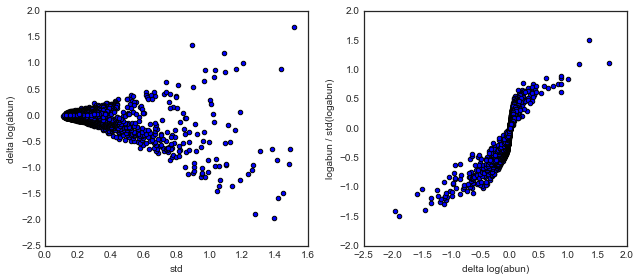

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].scatter(snr_schu['std'], snr_schu['delta_logabun'])
ax[0].set_xlabel('std')
ax[0].set_ylabel('delta log(abun)')

ax[1].scatter(snr_schu['delta_logabun'], snr_schu['snr'])
ax[1].set_xlabel('delta log(abun)')
ax[1].set_ylabel('logabun / std(logabun)')

fig.tight_layout()

I think this looks okay. For the most part, things with bigger differences in log abundance have higher signal to noise ratio, with the highest one being around 1 (delta is about 1.5, std is also about 1.5). Around delta = 0, this also looks okay: some of these have snr of zero (presumably bc their std is larger than the mean difference), but others are higher (presumably bc their std is quite small, so the small delta in mean is actually more meanginful).

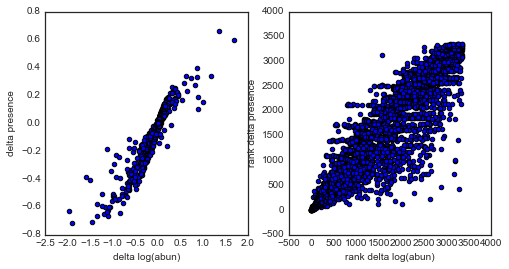

In [24]:
# delta log(abun) vs. delta(presence)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(snr_schu['delta_logabun'], snr_schu['delta_presence'])
ax[0].set_xlabel('delta log(abun)')
ax[0].set_ylabel('delta presence')

ax[1].scatter(snr_schu['rank_snr'], snr_schu['rank_delta_presence'])
ax[1].set_xlabel('rank delta log(abun)')
ax[1].set_ylabel('rank delta presence')


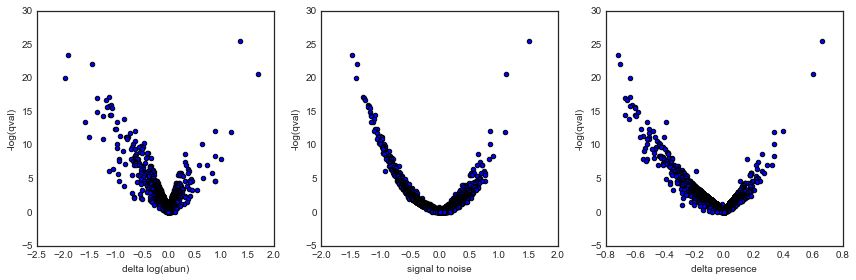

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(snr_schu['delta_logabun'], -np.log10(snr_schu['q_allsamples']))
ax[0].set_xlabel('delta log(abun)')
ax[0].set_ylabel('-log(qval)')

ax[1].scatter(snr_schu['snr'], -np.log10(snr_schu['q_allsamples']))
ax[1].set_xlabel('signal to noise')
ax[1].set_ylabel('-log(qval)')

ax[2].scatter(snr_schu['delta_presence'], -np.log10(snr_schu['q_allsamples']))
ax[2].set_xlabel('delta presence')
ax[2].set_ylabel('-log(qval)')
fig.tight_layout()

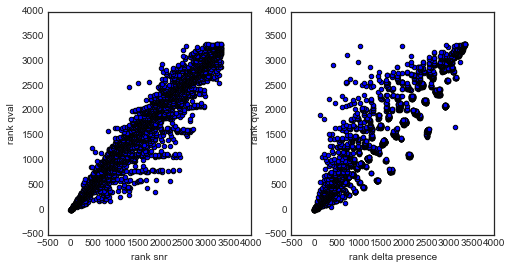

In [26]:
# Now let's look at rank in qvalues vs the other two deltas
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(snr_schu['rank_snr'], snr_schu['rank_qvalue'])
ax[0].set_xlabel('rank snr')
ax[0].set_ylabel('rank qval')

ax[1].scatter(snr_schu['rank_delta_presence'], snr_schu['rank_qvalue'])
ax[1].set_xlabel('rank delta presence')
ax[1].set_ylabel('rank qval')


Okay, it all looks pretty good to me (I think). I don't expect the results on "differential presence" vs "differential abundance" to be different, since for the most part they are pretty correlated...

Let's look at actual abundances of the top bugs!

In [56]:
top12 = snr_schu.sort_values(by='abs_snr', ascending=False).head(12)['denovo'].tolist()

d__denovo54
d__denovo17
d__denovo9
d__denovo43
d__denovo85
d__denovo44
d__denovo71
d__denovo72
d__denovo64
d__denovo61
d__denovo30
d__denovo69


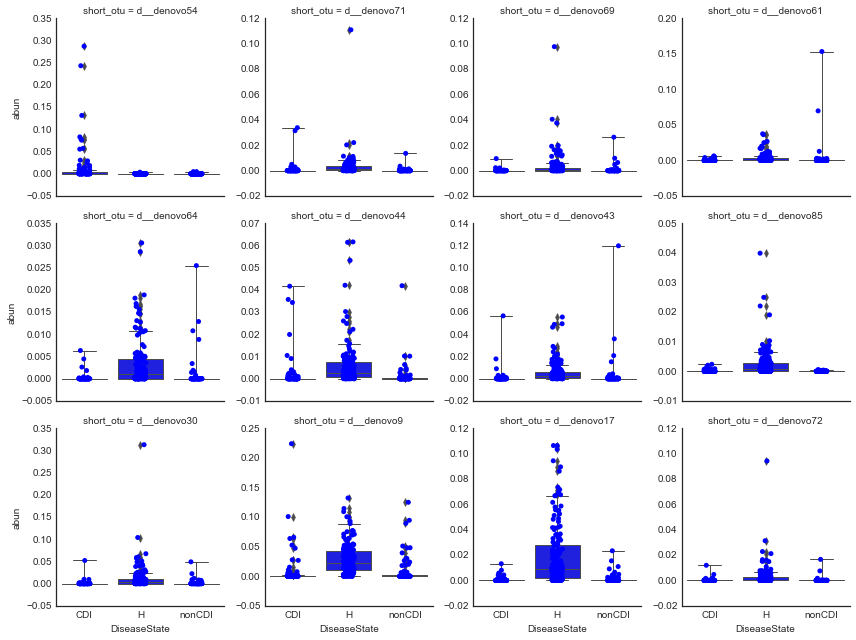

In [57]:
order = ['CDI', 'H', 'nonCDI']

print('\n'.join(top12))

g = sns.FacetGrid(data=tidydf_schu.query('short_otu == @top12'), 
                  col='short_otu', col_wrap=4, 
                  sharey=False)
g.map(sns.boxplot, 'DiseaseState', 'abun', order=order)
g.map(sns.stripplot, 'DiseaseState', 'abun', order=order)
plt.tight_layout()

Looks legit. Let's check their pvalues.

In [32]:
snr_schu.query('denovo == @top12')

,denovo,q_allsamples,std,CDI_logabun,H_logabun,nonCDI_logabun,delta_logabun,snr,abs_snr,CDI_presence,H_presence,nonCDI_presence,delta_presence,abs_delta_presence,rank_snr,rank_delta_presence,rank_qvalue
240,d__denovo54,2.764761e-26,0.894029,-3.132071,-4.482213,-4.347141,1.350142,1.510178,1.510178,0.666667,0.006494,0.089888,0.660173,0.660173,0,4,0
68640,d__denovo17,3.797850e-24,1.278392,-4.229315,-2.330248,-4.083475,-1.899067,-1.485513,1.485513,0.150538,0.863636,0.224719,-0.713099,0.713099,1,0,1
48672,d__denovo43,7.716115e-23,1.047309,-4.160595,-2.703975,-4.151946,-1.456619,-1.390820,1.390820,0.204301,0.909091,0.191011,-0.704790,0.704790,3,1,2
68448,d__denovo9,8.468912e-21,1.395212,-3.856358,-1.888808,-3.674399,-1.967550,-1.410216,1.410216,0.290323,0.922078,0.370787,-0.631755,0.631755,2,9,4
51624,d__denovo85,5.864601e-18,0.867089,-4.354201,-3.231763,-4.408028,-1.122438,-1.294490,1.294490,0.096774,0.733766,0.089888,-0.636992,0.636992,4,8,5
33216,d__denovo44,8.186220e-18,1.059749,-4.039402,-2.688488,-4.059529,-1.350914,-1.274750,1.274750,0.236559,0.902597,0.258427,-0.666038,0.666038,5,3,6
2592,d__denovo71,2.003738e-17,0.946509,-4.296379,-3.111225,-4.320415,-1.185154,-1.252132,1.252132,0.107527,0.759740,0.112360,-0.652213,0.652213,6,5,7
70224,d__denovo72,1.043803e-16,0.902200,-4.381843,-3.284621,-4.382933,-1.097223,-1.216163,1.216163,0.064516,0.688312,0.067416,-0.623796,0.623796,7,10,8
30600,d__denovo61,1.474035e-16,0.952329,-4.231056,-3.100913,-4.117776,-1.130143,-1.186714,1.186714,0.161290,0.798701,0.202247,-0.637411,0.637411,9,7,9
30696,d__denovo64,2.130074e-16,0.972127,-4.376187,-3.203706,-4.271130,-1.172482,-1.206100,1.206100,0.075269,0.675325,0.112360,-0.600056,0.600056,8,12,10


Yep, all of these have very small qvalues. Good!

What about the top 10 based on differential presence?

d__denovo17
d__denovo43
d__denovo56
d__denovo44
d__denovo54
d__denovo71
d__denovo146
d__denovo61
d__denovo85
d__denovo9
d__denovo72
d__denovo49


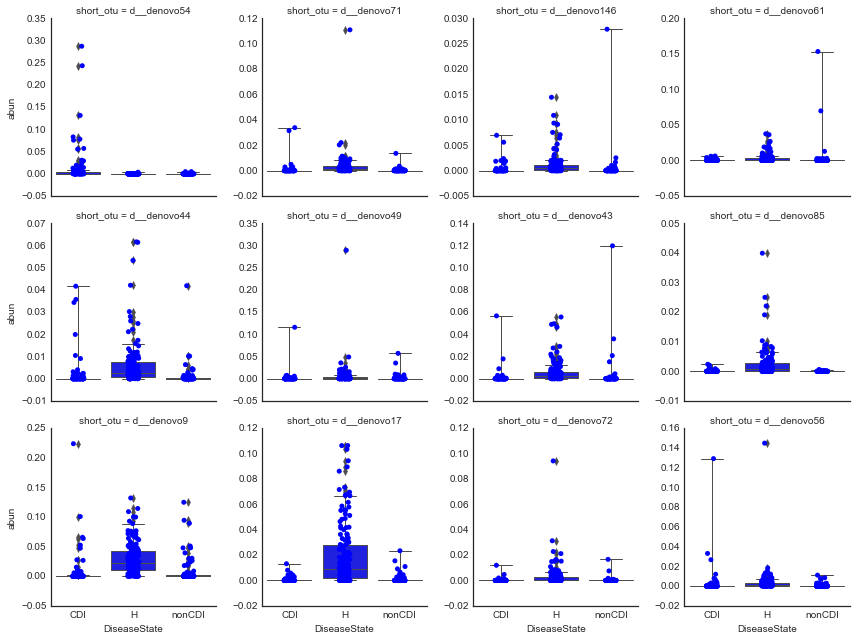

In [35]:
top12 = snr_schu.sort_values(by='rank_delta_presence').head(12)['denovo'].tolist()
print('\n'.join(top12))

g = sns.FacetGrid(data=tidydf_schu.query('short_otu == @top12'), 
                  col='short_otu', col_wrap=4, 
                  sharey=False)
g.map(sns.boxplot, 'DiseaseState', 'abun', order=order)
g.map(sns.stripplot, 'DiseaseState', 'abun', order=order)

## CRC Baxter

Ok, diarrhea is maybe too easy. Let's re-do this with the CRC dataset.

In [36]:
fotu = '../../data/clean/crc_baxter.otu_table.feather'
fmeta = '../../data/clean/crc_baxter.metadata.feather'

df_bax = read_dataframe(fotu)
df_bax.index.name = 'sample_id'

meta_bax = read_dataframe(fmeta)

In [37]:
# Convert OTU table to tidy
tidydf_bax = df_bax.reset_index().melt(id_vars='sample_id', value_name='abun', var_name='otu')
tidydf_bax['short_otu'] = tidydf_bax['otu'].str.split(';', 7).str[-1]
tidydf_bax.head()

,sample_id,otu,abun,short_otu
0,2045653,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,d__denovo15989
1,2087650,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,d__denovo15989
2,2963670,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,d__denovo15989
3,2527670,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,d__denovo15989
4,3453650,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,d__denovo15989


In [38]:
# Add metadata
tidydf_bax = pd.merge(tidydf_bax, meta_bax, left_on='sample_id', right_index=True)

In [39]:
# Convert to log abundance
min_abun = tidydf_bax['abun'].replace(0, np.nan).min() / 2
tidydf_bax['log_abun'] = np.log10(tidydf_bax['abun'] + min_abun)

In [41]:
meandf_bax = tidydf_bax.groupby(['otu', 'DiseaseState'])['log_abun'].mean()
meandf_bax.name = 'mean'
meandf_bax = meandf_bax.reset_index().pivot(index='otu', columns='DiseaseState', values='mean')
meandf_bax.columns = [i + '_logabun' for i in meandf_bax.columns]
meandf_bax['delta_logabun'] = meandf_bax['CRC_logabun'] - meandf_bax['H_logabun']

# Shorten index so it matches the denovo in qvals
meandf_bax.index = [i.rsplit(';', 1)[1] for i in meandf_bax.index]

meandf_bax.head()

,CRC_logabun,H_logabun,nonCRC_logabun,delta_logabun
d__denovo1003,-5.304617,-5.467990,-5.371333,0.163373
d__denovo10092,-5.616827,-5.615571,-5.638329,-0.001256
d__denovo10186,-5.625214,-5.642171,-5.617662,0.016956
d__denovo10406,-5.634404,-5.629280,-5.618179,-0.005123
d__denovo10549,-5.656570,-5.624741,-5.635096,-0.031828


In [42]:
# Need to get the std for each OTU (not split by DiseaseState)
stds_bax = tidydf_bax.groupby('otu')['log_abun'].std()
stds_bax.name = 'std'
stds_bax.index = [i.rsplit(';', 1)[1] for i in stds_bax.index]
stds_bax.head()

d__denovo1003     0.684136
d__denovo10092    0.252879
d__denovo10186    0.251498
d__denovo10406    0.228857
d__denovo10549    0.233074
Name: std, dtype: float64

In [43]:
# And differential presence/absence
tidydf_bax['present'] = tidydf_bax['abun'] > 0
mean_present_bax = tidydf_bax.groupby(['otu', 'DiseaseState'])['present'].mean()
mean_present_bax.name = 'mean'
mean_present_bax = mean_present_bax.reset_index().pivot(index='otu', columns='DiseaseState', values='mean')
mean_present_bax.columns = [i + '_presence' for i in mean_present_bax.columns]

mean_present_bax['delta_presence'] = mean_present_bax['CRC_presence'] - mean_present_bax['H_presence']

# Shorten index so it matches OTU names in the qvals
mean_present_bax.index = [i.rsplit(';', 1)[1] for i in mean_present_bax.index]

mean_present_bax.head()

,CRC_presence,H_presence,nonCRC_presence,delta_presence
d__denovo1003,0.200000,0.098837,0.161616,0.101163
d__denovo10092,0.033333,0.034884,0.020202,-0.001550
d__denovo10186,0.025000,0.017442,0.030303,0.007558
d__denovo10406,0.025000,0.029070,0.040404,-0.004070
d__denovo10549,0.008333,0.023256,0.020202,-0.014922


In [45]:
# Concatenate into signal-to-noise ratio df
snr_bax = pd.concat((stds_bax, meandf_bax), axis=1)

# Calculate signal to noise and absolute value of it
snr_bax['snr'] = snr_bax['delta_logabun'] / snr_bax['std']
snr_bax['abs_snr'] = abs(snr_bax['snr'])

# Also add differential presence
snr_bax = pd.concat((snr_bax, mean_present_bax), axis=1)
snr_bax['abs_delta_presence'] = abs(snr_bax['delta_presence'])

# Add q-values to the dataframe
snr_bax = pd.merge(
    qvals.query('study == "crc_baxter"')[['denovo', 'q_allsamples']].drop_duplicates(),
    snr_bax,
    left_on = 'denovo',
    right_index = True
)

# And rank them based on these differences
snr_bax = snr_bax.sort_values(by='abs_snr', ascending=False)
snr_bax['rank_snr'] = range(snr_bax.shape[0])
snr_bax = snr_bax.sort_values(by='abs_delta_presence', ascending=False)
snr_bax['rank_delta_presence'] = range(snr_bax.shape[0])
snr_bax = snr_bax.sort_values(by='q_allsamples')
snr_bax['rank_qvalue'] = range(snr_bax.shape[0])

snr_bax.sort_values(by='abs_snr', ascending=False).head()

,denovo,q_allsamples,std,CRC_logabun,H_logabun,nonCRC_logabun,delta_logabun,snr,abs_snr,CRC_presence,H_presence,nonCRC_presence,delta_presence,abs_delta_presence,rank_snr,rank_delta_presence,rank_qvalue
115058,d__denovo596,0.000008,0.646586,-5.046159,-5.619098,-5.585276,0.572940,0.886100,0.886100,0.275000,0.029070,0.050505,0.245930,0.245930,0,1,0
427110,d__denovo196,0.000622,0.770060,-4.983694,-5.591472,-5.541898,0.607778,0.789260,0.789260,0.250000,0.046512,0.070707,0.203488,0.203488,1,5,4
320562,d__denovo216,0.000477,0.854937,-4.908771,-5.578175,-5.496614,0.669404,0.782986,0.782986,0.258333,0.046512,0.095960,0.211822,0.211822,2,4,2
562310,d__denovo404,0.000265,0.653454,-5.150300,-5.656074,-5.591799,0.505774,0.774002,0.774002,0.183333,0.005814,0.040404,0.177519,0.177519,3,9,1
99848,d__denovo670,0.000622,0.462215,-5.315076,-5.667386,-5.660005,0.352310,0.762220,0.762220,0.150000,0.000000,0.005051,0.150000,0.150000,4,19,3


Sanity check plots.

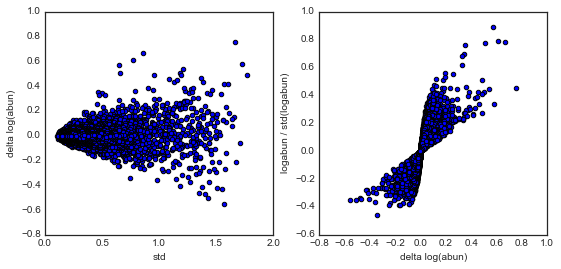

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].scatter(snr_bax['std'], snr_bax['delta_logabun'])
ax[0].set_xlabel('std')
ax[0].set_ylabel('delta log(abun)')

ax[1].scatter(snr_bax['delta_logabun'], snr_bax['snr'])
ax[1].set_xlabel('delta log(abun)')
ax[1].set_ylabel('logabun / std(logabun)')

Ah okay this looks much noisier. But still ok I think?

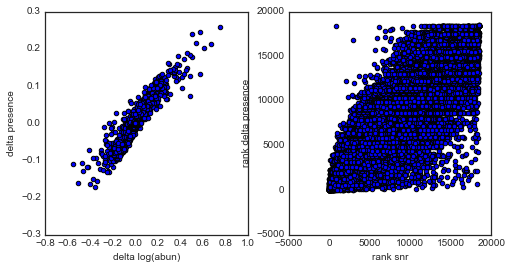

In [47]:
# delta log(abun) vs. delta(presence)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(snr_bax['delta_logabun'], snr_bax['delta_presence'])
ax[0].set_xlabel('delta log(abun)')
ax[0].set_ylabel('delta presence')

ax[1].scatter(snr_bax['rank_snr'], snr_bax['rank_delta_presence'])
ax[1].set_xlabel('rank snr')
ax[1].set_ylabel('rank delta presence')


Yes, these rankings are much less correlated. So in this case we might see differences in the two types of definitions for "top hits".

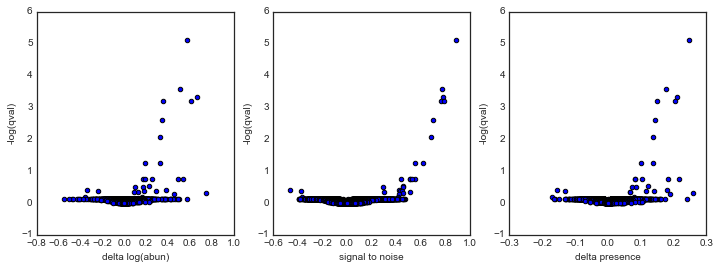

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(snr_bax['delta_logabun'], -np.log10(snr_bax['q_allsamples']))
ax[0].set_xlabel('delta log(abun)')
ax[0].set_ylabel('-log(qval)')

ax[1].scatter(snr_bax['snr'], -np.log10(snr_bax['q_allsamples']))
ax[1].set_xlabel('signal to noise')
ax[1].set_ylabel('-log(qval)')

ax[2].scatter(snr_bax['delta_presence'], -np.log10(snr_bax['q_allsamples']))
ax[2].set_xlabel('delta presence')
ax[2].set_ylabel('-log(qval)')


Huh, these are much messier data. Looking at the volcano plots, it's pretty clear that there are only a handful of significantly different bugs. And even though the ones with the highest signal to noise ratio (i.e. on the far right or left of the plot) aren't necessarily all significant, it does look like the bugs with highest SNR are also more significant than the others...?

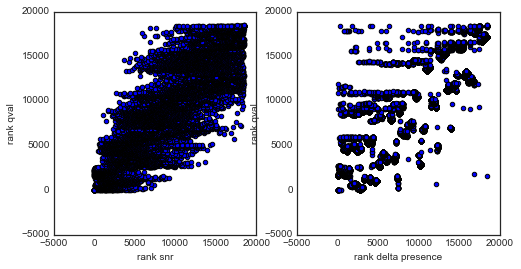

In [49]:
# Now let's look at rank in qvalues vs the other two deltas
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(snr_bax['rank_snr'], snr_bax['rank_qvalue'])
ax[0].set_xlabel('rank snr')
ax[0].set_ylabel('rank qval')

ax[1].scatter(snr_bax['rank_delta_presence'], snr_bax['rank_qvalue'])
ax[1].set_xlabel('rank delta presence')
ax[1].set_ylabel('rank qval')


Not super sure how to interpret this but I think for now I trust the signal-to-noise ratio calculation more!

d__denovo596
d__denovo196
d__denovo216
d__denovo404
d__denovo670
d__denovo1597
d__denovo664
d__denovo1172
d__denovo2218
d__denovo1011
d__denovo1822
d__denovo12156


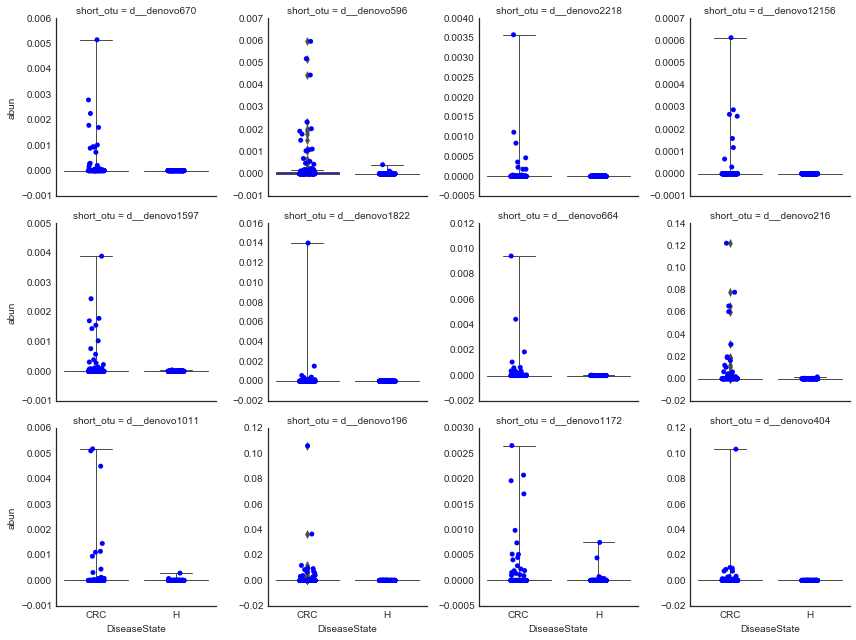

In [50]:
top12 = snr_bax.sort_values(by='abs_snr', ascending=False).head(12)['denovo'].tolist()
print('\n'.join(top12))

order = ['CRC', 'H']

g = sns.FacetGrid(data=tidydf_bax.query('short_otu == @top12'), 
                  col='short_otu', col_wrap=4, 
                  sharey=False)
g.map(sns.boxplot, 'DiseaseState', 'abun', order=order)
g.map(sns.stripplot, 'DiseaseState', 'abun', order=order)

In [51]:
snr_bax.query('denovo == @top12')

,denovo,q_allsamples,std,CRC_logabun,H_logabun,nonCRC_logabun,delta_logabun,snr,abs_snr,CRC_presence,H_presence,nonCRC_presence,delta_presence,abs_delta_presence,rank_snr,rank_delta_presence,rank_qvalue
115058,d__denovo596,0.000008,0.646586,-5.046159,-5.619098,-5.585276,0.572940,0.886100,0.886100,0.275000,0.029070,0.050505,0.245930,0.245930,0,1,0
562310,d__denovo404,0.000265,0.653454,-5.150300,-5.656074,-5.591799,0.505774,0.774002,0.774002,0.183333,0.005814,0.040404,0.177519,0.177519,3,9,1
320562,d__denovo216,0.000477,0.854937,-4.908771,-5.578175,-5.496614,0.669404,0.782986,0.782986,0.258333,0.046512,0.095960,0.211822,0.211822,2,4,2
99848,d__denovo670,0.000622,0.462215,-5.315076,-5.667386,-5.660005,0.352310,0.762220,0.762220,0.150000,0.000000,0.005051,0.150000,0.150000,4,19,3
427110,d__denovo196,0.000622,0.770060,-4.983694,-5.591472,-5.541898,0.607778,0.789260,0.789260,0.250000,0.046512,0.070707,0.203488,0.203488,1,5,4
152628,d__denovo1597,0.002497,0.495224,-5.314004,-5.659424,-5.625036,0.345419,0.697502,0.697502,0.150000,0.005814,0.020202,0.144186,0.144186,5,23,5
238168,d__denovo664,0.008669,0.473547,-5.330610,-5.654874,-5.620045,0.324264,0.684757,0.684757,0.150000,0.011628,0.030303,0.138372,0.138372,6,29,6
123586,d__denovo2218,0.054677,0.345276,-5.475180,-5.667386,-5.646238,0.192206,0.556675,0.556675,0.100000,0.000000,0.010101,0.100000,0.100000,8,101,7
546580,d__denovo1172,0.056766,0.524758,-5.290887,-5.614713,-5.606785,0.323826,0.617096,0.617096,0.166667,0.029070,0.040404,0.137597,0.137597,7,30,8
349292,d__denovo1011,0.178292,0.458382,-5.391274,-5.645991,-5.625345,0.254716,0.555686,0.555686,0.116667,0.011628,0.025253,0.105039,0.105039,9,83,10


Yep, as expected some of these bugs don't actually get pick up as significant. That's a bit strange...?

d__denovo18
d__denovo596
d__denovo362
d__denovo154
d__denovo216
d__denovo196
d__denovo338
d__denovo370
d__denovo402
d__denovo404
d__denovo274
d__denovo454


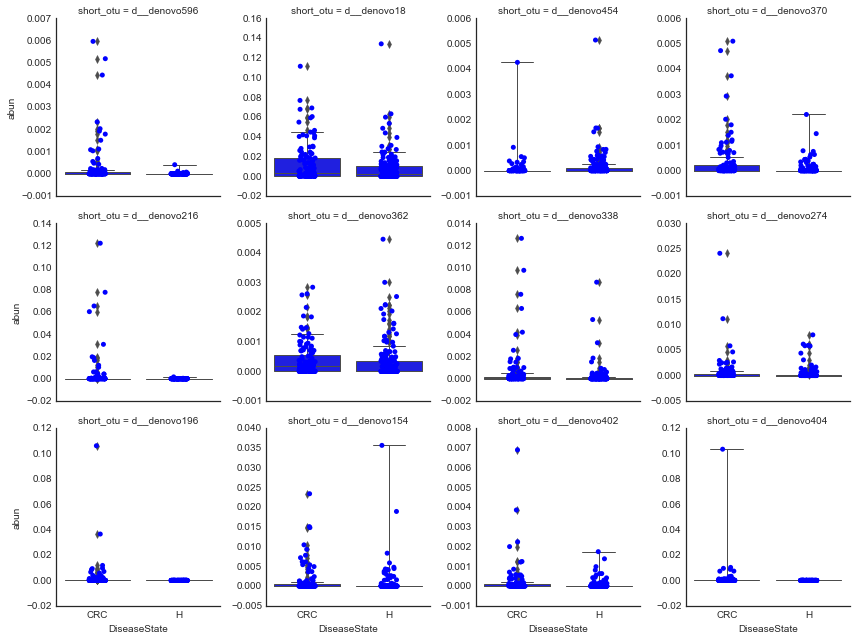

In [52]:
top12 = snr_bax.sort_values(by='rank_delta_presence', ascending=True).head(12)['denovo'].tolist()
print('\n'.join(top12))

order = ['CRC', 'H']

g = sns.FacetGrid(data=tidydf_bax.query('short_otu == @top12'), 
                  col='short_otu', col_wrap=4, 
                  sharey=False)
g.map(sns.boxplot, 'DiseaseState', 'abun', order=order)
g.map(sns.stripplot, 'DiseaseState', 'abun', order=order)

Interesting, the top 12 based on delta presence actually look less differentially present than the ones based on signal to noise. All of this makes me definitely trust signal to noise more.

Next steps: I need to write a script to make these figures for group meeting, these notebooks are becoming too unwieldy imo.